In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import pickle
import joblib

In [2]:
# return monthly average and regional longitude, latitude
# extract and group each month data
# after calculate the anomaly, remove the outliers
def month_data_sst(anom, month):
    month_group = anom.groupby("time.month").groups # group into seasons, use groups to read each group
    month_index = month_group[month]
    month_anom = anom[month_index,:,:,:]
    #### THE THRESHOLD????
    #month_anom = xr.where((month_anom>5), 0, month_anom)
    return month_anom


# calculate normalized anomalies -- CESM
# climatology based on 1976 to 2005 
def nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1976", "2005")).load()
    #lons_xr = dataset['lon'] # from -12W to 36E
    #lats_xr = dataset['lat'] # from 35N to 73N
    rr_clm = ds_clm

    gb_clm = rr_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    prcp_anom = (gb - gb_clm.mean(dim="time")).groupby("time.month")/gb_clm.std(dim="time")
    # no normalization for calculating the nino index  # normalized
    # important to add two times groupby
    # gb.mean: only 12 month -- average daily prcp at each month
    # prcp_anom -- each month one anomaly
    return prcp_anom

In [3]:
def data_load_cesm_nino(fn, start, end): # 'TP' 'NA' 'MD'
    ds_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_xr = ds_xr.sel(time=slice(start, end)).load()
    # convert 0-360 to -180-180
    #ds_xr = ds_xr.assign_coords(lon=(((ds_xr.lon + 180) % 360) - 180))
    # How to extract the desired region? -- by calculation
    reg_lon_xr = ds_xr['nlon'] # from -40.375W to 75.375E
    reg_lat_xr = ds_xr['nlat'] # from 25.375N to 75.375N
    temp_xr = ds_xr['SST']
    xr1 = temp_xr[:,:,149:206,177:285]
    xr1 = xr1.squeeze()
    # prec_xr = prec_xr1*1000*86400 # from m/s to mm/day
    # time, lat, lon
    return xr1, reg_lat_xr, reg_lon_xr

In [4]:
# first calculate all the sst anomaly
import os
path = r'C:/Users/yzh086/OneDrive - University of Bergen/PhD_lit/PhD_lit/task1/Data/CESM1/sst'
filelist = os.listdir(path)

pathlist = []
for i in range(len(filelist)):
    temp = path + '/' + filelist[i]
    pathlist.append(temp)
    
fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

In [46]:
temp_xr['SST'][1,0,149:206,177:285].TLON

<xarray.DataArray 'TLONG' (nlon: 108)>
array([159.68750444, 160.81250448, 161.93750451, 163.06250454,
       164.18750457, 165.3125046 , 166.43750463, 167.56250466,
       168.68750469, 169.81250473, 170.93750476, 172.06250479,
       173.18750482, 174.31250485, 175.43750488, 176.56250491,
       177.68750494, 178.81250498, 179.93750501, 181.06250504,
       182.18750507, 183.3125051 , 184.43750513, 185.56250516,
       186.6875052 , 187.81250523, 188.93750526, 190.06250529,
       191.18750532, 192.31250535, 193.43750538, 194.56250541,
       195.68750545, 196.81250548, 197.93750551, 199.06250554,
       200.18750557, 201.3125056 , 202.43750563, 203.56250566,
       204.6875057 , 205.81250573, 206.93750576, 208.06250579,
       209.18750582, 210.31250585, 211.43750588, 212.56250592,
       213.68750595, 214.81250598, 215.93750601, 217.06250604,
       218.18750607, 219.3125061 , 220.43750613, 221.56250617,
       222.6875062 , 223.81250623, 224.93750626, 226.06250629,
       227.18750632, 228.31250635, 229.43750638, 230.56250642,
       231.68750645, 232.81250648, 233.93750651, 235.06250654,
       236.18750657, 237.3125066 , 238.43750664, 239.56250667,
       240.6875067 , 241.81250673, 242.93750676, 244.06250679,
       245.18750682, 246.31250685, 247.43750689, 248.56250692,
       249.68750695, 250.81250698, 251.93750701, 253.06250704,
       254.18750707, 255.3125071 , 256.43750714, 257.56250717,
       258.6875072 , 259.81250723, 260.93750726, 262.06250729,
       263.18750732, 264.31250736, 265.43750739, 266.56250742,
       267.68750745, 268.81250748, 269.93750751, 271.06250754,
       272.18750757, 273.31250761, 274.43750764, 275.56250767,
       276.6875077 , 277.81250773, 278.93750776, 280.06250779])
Coordinates:
    TLAT     (nlon) float64 -78.69 -78.69 -78.69 -78.69 ... -78.69 -78.69 -78.69
    TLONG    (nlon) float64 159.7 160.8 161.9 163.1 ... 276.7 277.8 278.9 280.1
    ULAT     (nlon) float64 -78.42 -78.42 -78.42 -78.42 ... -78.42 -78.42 -78.42
    ULONG    (nlon) float64 160.3 161.4 162.5 163.6 ... 277.3 278.4 279.5 280.6
    time     object 1920-02-01 00:00:00
    z_t      float32 500.0
Dimensions without coordinates: nlon
Attributes:
    long_name:  array of t-grid longitudes
    units:      degrees_east

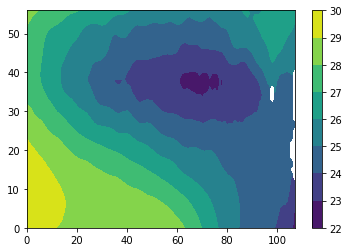

In [48]:
plt.contourf(temp_xr['SST'][1,0,149:206,177:285])
plt.colorbar()

In [5]:
# preprocess SST -- all data together
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## change parameter for different region ##

fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

sst_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_nino(fn1, '192002', '200601')

In [59]:
sst_xr

<xarray.DataArray 'SST' (time: 1032, nlat: 57, nlon: 108)>
array([[[29.243452, 29.210434, 29.207172, ..., 23.493948, 23.083162,
         22.685024],
        [29.280598, 29.246246, 29.240347, ..., 23.528378, 23.10828 ,
         22.758461],
        [29.31136 , 29.276857, 29.270403, ..., 23.569021, 23.134838,
         22.815235],
        ...,
        [28.179024, 28.075483, 27.97526 , ..., 26.246988, 26.1739  ,
         26.068426],
        [28.250221, 28.160559, 28.072437, ..., 26.27683 , 26.223095,
         26.13671 ],
        [28.3077  , 28.23408 , 28.161732, ..., 26.300426, 26.273643,
         26.222046]],

       [[29.618263, 29.576889, 29.5471  , ..., 24.727524, 24.3347  ,
         23.992962],
        [29.633413, 29.59718 , 29.572468, ..., 24.833656, 24.461285,
         24.181477],
        [29.647385, 29.618614, 29.599285, ..., 24.93699 , 24.587564,
         24.340755],
...
        [29.730297, 29.649553, 29.56287 , ..., 26.12358 , 26.143543,
         26.139315],
        [29.793636, 29.728075, 29.650824, ..., 26.168552, 26.18788 ,
         26.195   ],
        [29.829447, 29.774065, 29.70787 , ..., 26.211262, 26.229649,
         26.245907]],

       [[29.857431, 29.916048, 29.976343, ..., 22.372074, 22.196592,
         21.729218],
        [29.886606, 29.952106, 30.015024, ..., 22.42732 , 22.220057,
         21.7432  ],
        [29.917473, 29.987246, 30.050562, ..., 22.478611, 22.225948,
         21.693506],
        ...,
        [29.056269, 29.014154, 28.972294, ..., 26.042768, 25.990696,
         25.937864],
        [29.117716, 29.082638, 29.045755, ..., 26.108528, 26.065657,
         26.029955],
        [29.157324, 29.131569, 29.100546, ..., 26.167498, 26.136341,
         26.115559]]], dtype=float32)
Coordinates:
    TLAT     (nlat, nlon) float64 -10.02 -10.02 -10.02 ... 4.907 4.906 4.906
    TLONG    (nlat, nlon) float64 159.7 160.8 161.9 163.1 ... 277.8 278.9 280.1
    ULAT     (nlat, nlon) float64 -9.883 -9.883 -9.883 ... 5.038 5.037 5.037
    ULONG    (nlat, nlon) float64 160.3 161.4 162.5 163.6 ... 278.4 279.5 280.6
  * time     (time) object 1920-02-01 00:00:00 ... 2006-01-01 00:00:00
    z_t      float32 500.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [6]:
# calculate anomaly
sst_anom = nor_anom(sst_xr)

# detrend the time series at each grid point
#sst_danom = detrend_dim(sst_anom, 'time', deg=1)

# extract and group each season data
#anom_ensemble = sst_anom
anom_original = sst_anom

data = np.squeeze(sst_anom.values) # remove dimension = 1
time = temp_xr.time
tlat = sst_anom.TLAT
tlong = sst_anom.TLONG
anom_ensemble = xr.DataArray(data, 
                    coords={'time':time, 
                            'TLAT':(("nlat", "nlon"), np.array(tlat)),
                            'TLONG':(("nlat", "nlon"), np.array(tlong))},  # format for multiple dimensions
                    dims=['time', 'nlat', 'nlon'])

In [61]:
anom_ensemble

<xarray.DataArray (time: 1032, nlat: 57, nlon: 108)>
array([[[-2.69148976e-01, -3.88141453e-01, -4.48209018e-01, ...,
         -3.79345566e-01, -4.56120819e-01, -3.46041769e-01],
        [-1.45040661e-01, -2.68993258e-01, -3.31783533e-01, ...,
         -3.81137669e-01, -4.73722190e-01, -3.35638702e-01],
        [-3.18665951e-02, -1.59890562e-01, -2.24078059e-01, ...,
         -3.74245226e-01, -4.78186190e-01, -3.09796840e-01],
        ...,
        [-2.28882268e-01, -3.14619273e-01, -3.81970912e-01, ...,
          2.76832394e-02,  6.77188486e-02,  7.86356442e-03],
        [-1.54590577e-01, -2.31191114e-01, -2.92758971e-01, ...,
          8.04947764e-02,  1.68513447e-01,  1.01573959e-01],
        [-8.51917490e-02, -1.50003642e-01, -1.98775724e-01, ...,
          1.11303248e-01,  2.68376112e-01,  2.35903114e-01]],

       [[ 8.82524014e-01,  7.30542779e-01,  6.14994824e-01, ...,
         -1.95605516e-01, -2.82575935e-01, -2.49157012e-01],
        [ 9.21492219e-01,  7.84261644e-01,  6.76379859e-01, ...,
         -1.45953715e-01, -2.44783744e-01, -1.76616922e-01],
        [ 9.54012811e-01,  8.36160243e-01,  7.37940371e-01, ...,
         -1.00876272e-01, -1.96100235e-01, -9.97249782e-02],
...
          5.64120293e-01,  5.13581455e-01,  3.81398141e-01],
        [ 1.30931520e+00,  1.22027063e+00,  1.10668063e+00, ...,
          5.58400452e-01,  5.26203156e-01,  4.29204851e-01],
        [ 1.40681529e+00,  1.32679296e+00,  1.21760058e+00, ...,
          5.57586014e-01,  5.42997599e-01,  4.80529487e-01]],

       [[ 2.84006572e+00,  3.09557652e+00,  3.22279763e+00, ...,
          1.63330764e-01,  1.18142605e-01,  2.27857679e-02],
        [ 3.01114559e+00,  3.25657177e+00,  3.35600805e+00, ...,
          1.49781495e-01,  1.03136495e-01,  2.87548616e-03],
        [ 3.18447971e+00,  3.39384294e+00,  3.44187880e+00, ...,
          1.38382226e-01,  8.86787623e-02, -3.30455974e-02],
        ...,
        [ 5.41391432e-01,  5.06639957e-01,  4.75220829e-01, ...,
          1.40322745e-01,  8.54049698e-02,  5.41701242e-02],
        [ 6.30648553e-01,  5.94445169e-01,  5.59547424e-01, ...,
          1.45234197e-01,  1.00554258e-01,  9.70625654e-02],
        [ 7.14388013e-01,  6.80258632e-01,  6.42461658e-01, ...,
          1.44100174e-01,  1.09791659e-01,  1.31880805e-01]]],
      dtype=float32)
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
    TLAT     (nlat, nlon) float64 -10.02 -10.02 -10.02 ... 4.907 4.906 4.906
    TLONG    (nlat, nlon) float64 159.7 160.8 161.9 163.1 ... 277.8 278.9 280.1
Dimensions without coordinates: nlat, nlon

In [7]:
##### ensemble #####
for i in range(1,len(filelist)):

    fn1 = pathlist[i]
    sst_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_nino(fn1, '192002', '200601')

    # calculate anomaly
    sst_anom = nor_anom(sst_xr)

    # detrend the time series at each grid point
    #sst_danom = detrend_dim(sst_anom, 'time', deg=1)
    
    data = np.squeeze(sst_anom.values) # remove dimension = 1
    time = temp_xr.time
    tlat = sst_anom.TLAT
    tlong = sst_anom.TLONG
    anom_gb_temp = xr.DataArray(data, 
                        coords={'time':time, 
                                      'TLAT':(("nlat", "nlon"), np.array(tlat)),
                                      'TLONG':(("nlat", "nlon"), np.array(tlong))}, 
                        dims=['time', 'nlat', 'nlon'])


    anom_ensemble = xr.concat([anom_ensemble,anom_gb_temp], dim='time')

In [8]:
### save and load as netcdf ###
anom_ensemble.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino.nc'
                        )

In [9]:
anom_ensemble

<xarray.DataArray (time: 41280, nlat: 57, nlon: 108)>
array([[[-0.26914898, -0.38814145, -0.44820902, ..., -0.37934557,
         -0.45612082, -0.34604177],
        [-0.14504066, -0.26899326, -0.33178353, ..., -0.38113767,
         -0.4737222 , -0.3356387 ],
        [-0.0318666 , -0.15989056, -0.22407806, ..., -0.37424523,
         -0.4781862 , -0.30979684],
        ...,
        [-0.22888227, -0.31461927, -0.3819709 , ...,  0.02768324,
          0.06771885,  0.00786356],
        [-0.15459058, -0.23119111, -0.29275897, ...,  0.08049478,
          0.16851345,  0.10157396],
        [-0.08519175, -0.15000364, -0.19877572, ...,  0.11130325,
          0.2683761 ,  0.23590311]],

       [[ 0.882524  ,  0.7305428 ,  0.6149948 , ..., -0.19560552,
         -0.28257594, -0.24915701],
        [ 0.9214922 ,  0.78426164,  0.67637986, ..., -0.14595371,
         -0.24478374, -0.17661692],
        [ 0.9540128 ,  0.83616024,  0.7379404 , ..., -0.10087627,
         -0.19610023, -0.09972498],
...
        [ 1.8468004 ,  1.8671875 ,  1.8949486 , ...,  0.02890169,
          0.04842218,  0.05042207],
        [ 1.8211577 ,  1.8532915 ,  1.8907521 , ...,  0.04700237,
          0.04298146,  0.03251121],
        [ 1.773177  ,  1.8092815 ,  1.8515999 , ...,  0.05447546,
          0.03430579,  0.03145718]],

       [[ 0.5817692 ,  0.8242251 ,  1.0240157 , ...,  0.39021915,
          0.41569918,  0.5211882 ],
        [ 0.6915534 ,  0.91537297,  1.088747  , ...,  0.38812745,
          0.4393497 ,  0.55795807],
        [ 0.8214447 ,  1.0026416 ,  1.1381793 , ...,  0.39208135,
          0.46340996,  0.6001024 ],
        ...,
        [ 1.4229358 ,  1.3910081 ,  1.380391  , ...,  0.71332026,
          0.7487278 ,  0.81442165],
        [ 1.4141654 ,  1.3887284 ,  1.385383  , ...,  0.7193777 ,
          0.76372766,  0.8231292 ],
        [ 1.3852934 ,  1.3724309 ,  1.3825939 , ...,  0.72976124,
          0.7828827 ,  0.8334878 ]]], dtype=float32)
Coordinates:
  * time     (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
    TLAT     (time, nlat, nlon) float64 -10.02 -10.02 -10.02 ... 4.906 4.906
    TLONG    (time, nlat, nlon) float64 159.7 160.8 161.9 ... 277.8 278.9 280.1
Dimensions without coordinates: nlat, nlon

In [63]:
##### save the data -- no need to run the previous again #####

df = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_nino.txt' 
          ,'wb')
pickle.dump(anom_ensemble, df)
df.close()

In [4]:
##### open the file for next use #####

df2 = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\sst_nino.txt' 
          ,'rb')
anom_ensemble = pickle.load(df2)
df2.close()

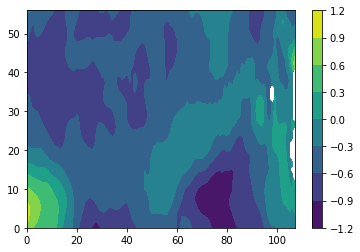

In [67]:
plt.contourf(anom_ensemble[1,:,:])
plt.colorbar()

In [5]:
anom_ensemble[1,:,:]

<xarray.DataArray (nlat: 57, nlon: 108)>
array([[ 0.882524  ,  0.7305428 ,  0.6149948 , ..., -0.19560552,
        -0.28257594, -0.24915701],
       [ 0.9214922 ,  0.78426164,  0.67637986, ..., -0.14595371,
        -0.24478374, -0.17661692],
       [ 0.9540128 ,  0.83616024,  0.7379404 , ..., -0.10087627,
        -0.19610023, -0.09972498],
       ...,
       [-0.3427564 , -0.41839135, -0.48904502, ..., -0.40721026,
        -0.45309326, -0.4572916 ],
       [-0.2827188 , -0.3443579 , -0.4049164 , ..., -0.49268708,
        -0.48487395, -0.5287184 ],
       [-0.21489966, -0.2685908 , -0.31937099, ..., -0.56355226,
        -0.5001472 , -0.56237507]], dtype=float32)
Coordinates:
    time     object 1920-02-01 00:00:00
    TLAT     (nlat, nlon) float64 -10.02 -10.02 -10.02 ... 4.907 4.906 4.906
    TLONG    (nlat, nlon) float64 159.7 160.8 161.9 163.1 ... 277.8 278.9 280.1
Dimensions without coordinates: nlat, nlon

In [10]:
# Nino 1+2 (0-10s, 90W-80W)
nino_1_2 = anom_ensemble[:,:38,-10:].mean(axis=1).mean(axis=1).values.reshape(40, 1032)

In [13]:
pd.DataFrame(nino_1_2).to_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_1_2.csv')

In [22]:
df = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_1_2.txt' 
          ,'wb')
pickle.dump(nino_1_2, df)
df.close()

In [23]:
##### open the file for next use #####

df2 = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_1_2.txt' 
          ,'rb')
ensemble = pickle.load(df2)
df2.close()

In [25]:
ensemble[0]

array([-0.21434875, -0.07674615, -0.13351688, ...,  0.46335548,
       -0.07555435, -0.16270116], dtype=float32)

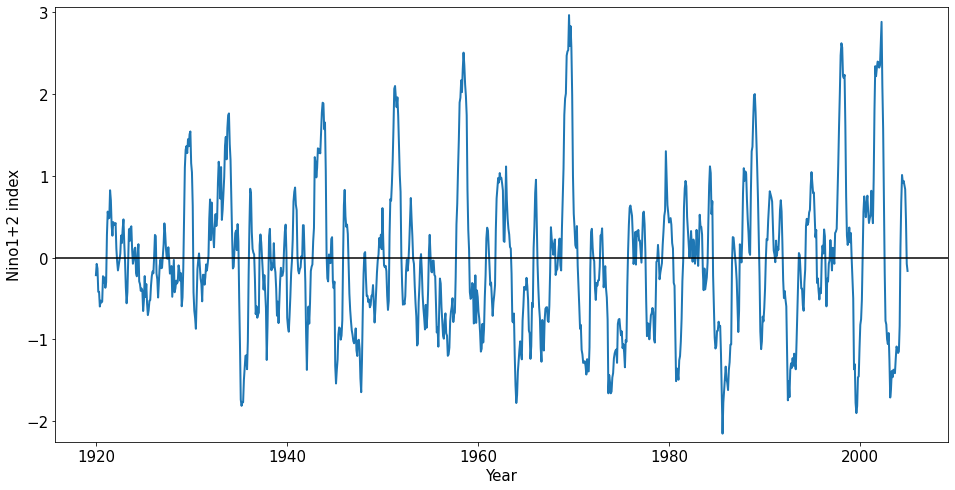

In [26]:
fig = plt.subplots(figsize=(16,8))
fig = plt.gcf()
days = np.linspace(1920,2005,1032)
plt.plot(days, ensemble[0], linewidth=2)
plt.axhline(0, color='k')
plt.xlabel('Year',fontsize = 15)
plt.ylabel('Nino1+2 index',fontsize = 15)   
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.ylim(np.min(ensemble[0]-0.1), np.max(ensemble[0]+0.1))

fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_1_2.png')

In [14]:
# Nino 3.4
nino_3_4 = anom_ensemble[:,20:,27:73].mean(axis=1).mean(axis=1).values.reshape(40, 1032)

In [15]:
pd.DataFrame(nino_3_4).to_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_3_4.csv')

In [31]:
df = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_3_4.txt' 
          ,'wb')
pickle.dump(nino_3_4, df)
df.close()

In [44]:
##### open the file for next use #####

df2 = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_3_4.txt' 
          ,'rb')
ensemble = pickle.load(df2)
df2.close()

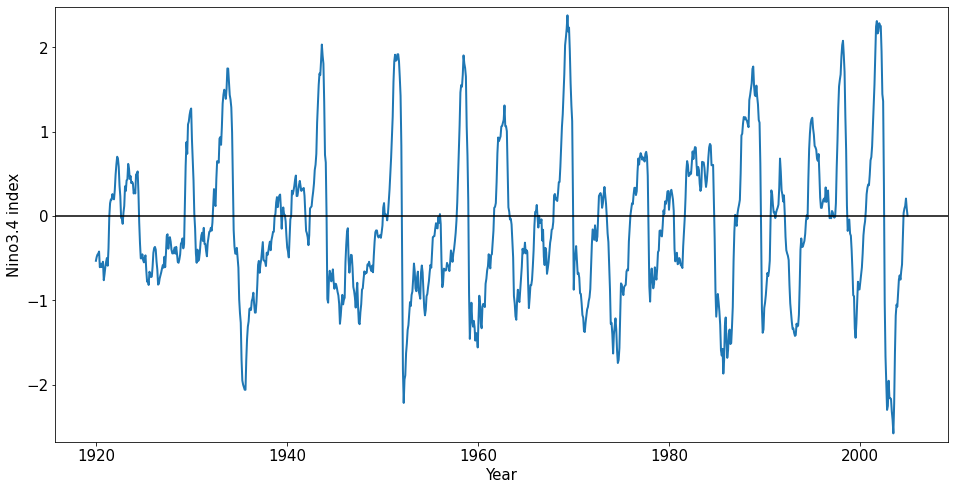

In [45]:
fig = plt.subplots(figsize=(16,8))
fig = plt.gcf()
days = np.linspace(1920,2005,1032)
plt.plot(days, ensemble[0], linewidth=2)
plt.axhline(0, color='k')
plt.xlabel('Year',fontsize = 15)
plt.ylabel('Nino3.4 index',fontsize = 15)   
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.ylim(np.min(ensemble[0]-0.1), np.max(ensemble[0]+0.1))

#fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_3_4.png')

(-2.2246100902557373, 1.892165184020996)

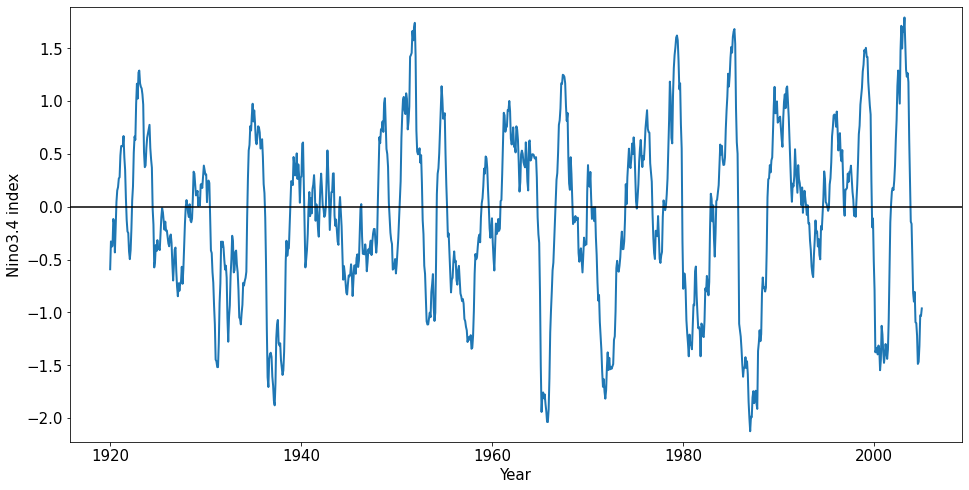

In [48]:
fig = plt.subplots(figsize=(16,8))
fig = plt.gcf()
days = np.linspace(1920,2005,1032)
plt.plot(days, ensemble[2], linewidth=2)
plt.axhline(0, color='k')
plt.xlabel('Year',fontsize = 15)
plt.ylabel('Nino3.4 index',fontsize = 15)   
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.ylim(np.min(ensemble[2]-0.1), np.max(ensemble[2]+0.1))


In [16]:
# Nino 3
nino3 = anom_ensemble[:,20:,46:-9].mean(axis=1).mean(axis=1).values.reshape(40, 1032)

In [17]:
pd.DataFrame(nino3).to_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_3.csv')

In [35]:
df = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino3.txt' 
          ,'wb')
pickle.dump(nino3, df)
df.close()

In [42]:
##### open the file for next use #####

df2 = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino3.txt' 
          ,'rb')
ensemble = pickle.load(df2)
df2.close()

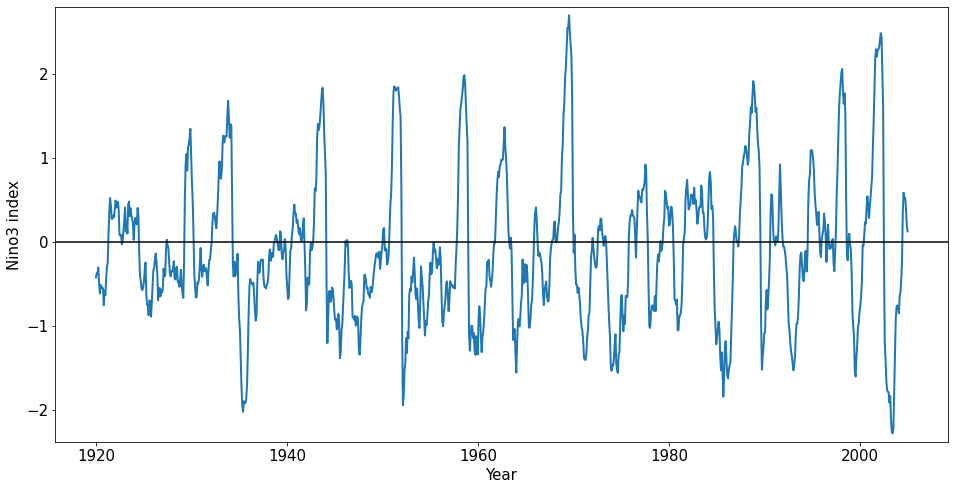

In [43]:
fig = plt.subplots(figsize=(16,8))
fig = plt.gcf()
days = np.linspace(1920,2005,1032)
plt.plot(days, ensemble[0], linewidth=2)
plt.axhline(0, color='k')
plt.xlabel('Year',fontsize = 15)
plt.ylabel('Nino3 index',fontsize = 15)   
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.ylim(np.min(ensemble[0]-0.1), np.max(ensemble[0]+0.1))

fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino3.png')

In [18]:
# Nino 4
nino4 = anom_ensemble[:,20:,:46].mean(axis=1).mean(axis=1).values.reshape(40, 1032)

In [19]:
pd.DataFrame(nino4).to_csv(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino_4.csv')

In [40]:
df = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino4.txt' 
          ,'wb')
pickle.dump(nino4, df)
df.close()

In [46]:
##### open the file for next use #####

df2 = open(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino4.txt' 
          ,'rb')
ensemble = pickle.load(df2)
df2.close()

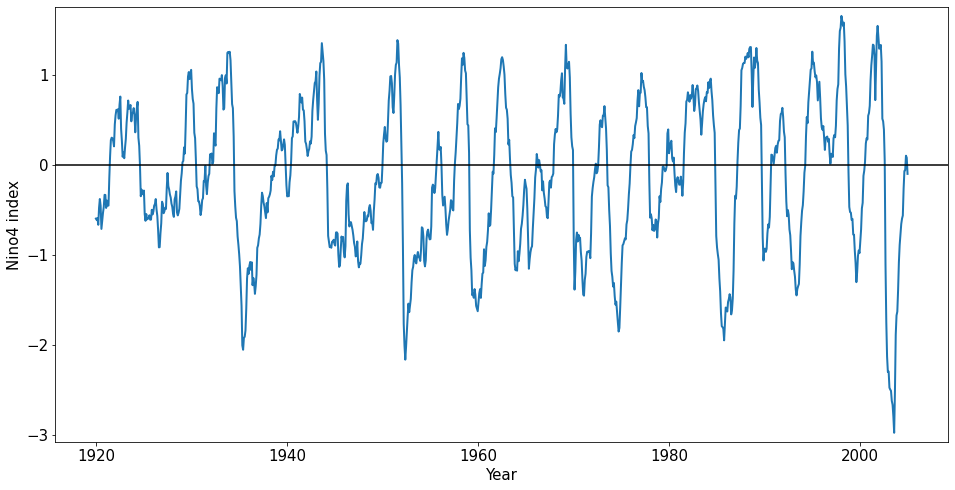

In [47]:
# visualize
# plot
fig = plt.subplots(figsize=(16,8))
fig = plt.gcf()
days = np.linspace(1920,2005,1032)
plt.plot(days, ensemble[0], linewidth=2)
plt.axhline(0, color='k')
plt.xlabel('Year',fontsize = 15)
plt.ylabel('Nino4 index',fontsize = 15)   
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)
plt.ylim(np.min(ensemble[0]-0.1), np.max(ensemble[0]+0.1))

fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\NINO\nino4.png')